In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [44]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/101410/bvals')

In [45]:
diff_indices = np.where(bvals_all_100206 != bvals_all_100307)[0]

In [46]:
diff_indices

array([  2,   9,  11,  12,  22,  25,  26,  31,  35,  37,  52,  53,  56,
        61,  63,  67,  69,  73,  74,  96,  97, 103, 113, 121, 134, 136,
       138, 142, 143, 152, 156, 158, 162, 164, 169, 171, 173, 189, 195,
       203, 204, 239, 246, 258, 259, 268, 269])

In [26]:
diff_indices

array([ 12,  37,  69,  88,  97, 102, 137, 138, 142, 169, 173, 198, 258,
       286])

In [ ]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [ ]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

normalized_scan_val_set_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [4]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [5]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3
bvals_val_set_sub = bvals_all_val_set[rand_sub_bval_indice_100206]*1e-3

In [6]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]
normalized_scan_val_set_sub = normalized_scan_val_set_full[:, rand_sub_bval_indice_100206]

In [7]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]
big_b_indice_val_set_sub = np.where(bvals_val_set_sub != 0.005)[0]

In [8]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]
bvals_val_set_sub_no_b5 = bvals_val_set_sub[big_b_indice_val_set_sub]

In [9]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]
normalized_scan_val_set_sub_no_b5 = normalized_scan_val_set_sub[:, big_b_indice_val_set_sub]

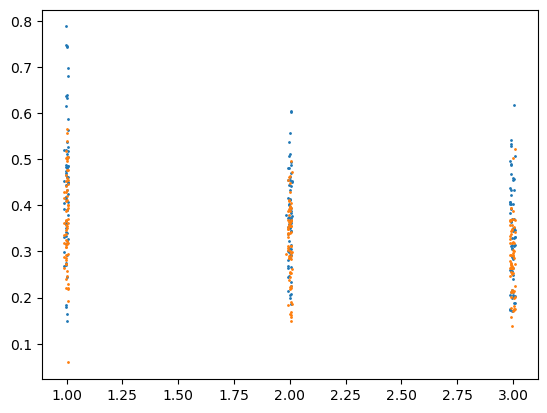

In [10]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_val_set_sub_no_b5, normalized_scan_val_set_sub_no_b5[42,:], "o", markersize = 1)

In [11]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100307/bvecs')

In [12]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

n_val_set_sub = n_val_set_all[:, rand_sub_bval_indice_100206]
n_val_set_sub_no_b5 = n_val_set_sub[:,big_b_indice_val_set_sub].T
print(n_val_set_sub_no_b5.shape)

b_values_val_set_sub_no_b5 = torch.FloatTensor(bvals_val_set_sub_no_b5)
gradient_directions_val_set_sub_no_b5 = torch.FloatTensor(n_val_set_sub_no_b5)

(196, 3)
(196, 3)


In [13]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [14]:
val_set = torch.from_numpy(normalized_scan_val_set_sub_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([740145, 196])
<class 'torch.Tensor'>


In [15]:
# bvals_num = len(b_values_100206_sub_no_b5)
# net = network.BallStickNet(bvals_num)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr = 0.00001)

net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [16]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]


# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs_train = 0
num_bad_epochs_val = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad training epochs: {}; Bad validation epochs: {}".format(epoch, num_bad_epochs_train, num_bad_epochs_val))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    temp_model = net.state_dict()
    val_net = network.BallStickNet(gradient_directions_val_set_sub_no_b5, b_values_val_set_sub_no_b5)
    val_net.load_state_dict(temp_model)
    val_net.eval()
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = val_net(val_set)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss = val_loss.item()
        val_loss_list.append(running_val_loss)
        print("Validation Loss: {}".format(running_val_loss))

    if running_train_loss < best_train_loss:
        print("############### Saving good model for training set ###############################")
        final_model_trainset = net.state_dict()
        best_train_loss = running_train_loss
        num_bad_epochs_train = 0
        
        if running_val_loss < best_val_loss:
            print("############### Saving good model for validation set ###############################")
            final_model_valset = net.state_dict()
            best_val_loss = running_val_loss
            num_bad_epochs_val = 0
        else:
            if running_val_loss >= best_val_loss:
                num_bad_epochs_val += 1
    else:
        
        if running_train_loss >= best_train_loss:
            num_bad_epochs_train = num_bad_epochs_train + 1
            if num_bad_epochs_train == patience:
                print("Done, best training loss per epoch: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
                break
        if running_val_loss >= best_val_loss:
            num_bad_epochs_val = num_bad_epochs_val + 1
            
        if running_val_loss < best_val_loss:
            best_val_loss = running_val_loss
            num_bad_epochs_val = 0
            print("ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. ")

            
print("Done") 
net.load_state_dict(final_model_trainset)
net.load_state_dict(final_model_valset)

-----------------------------------------------------------------
Epoch: 0; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.55it/s]


Loss: 2597.899758771062; Average Loss: 0.35548710437480324
Validation Loss: 0.24253235757350922
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 1; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.31it/s]


Loss: 618.0138018182479; Average Loss: 0.0845667490172753
Validation Loss: 0.04432647302746773
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 2; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.62it/s]


Loss: 460.20185852469876; Average Loss: 0.062972339699603
Validation Loss: 0.044108424335718155
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 3; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.59it/s]


Loss: 457.59561997279525; Average Loss: 0.06261571154526481
Validation Loss: 0.04413482919335365
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 4; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.68it/s]


Loss: 456.93533493950963; Average Loss: 0.06252536055548845
Validation Loss: 0.04369911924004555
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 5; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.97it/s]


Loss: 455.9649795200676; Average Loss: 0.062392580667770606
Validation Loss: 0.04370542988181114
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 6; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.78it/s]


Loss: 456.0252337451093; Average Loss: 0.06240082563561977
Validation Loss: 0.043579041957855225
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 7; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.30it/s]


Loss: 455.38160178717226; Average Loss: 0.062312753391786026
Validation Loss: 0.04362928867340088
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 8; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.87it/s]


Loss: 455.06684675067663; Average Loss: 0.06226968346342045
Validation Loss: 0.0437895841896534
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 9; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.24it/s]


Loss: 454.9793302840553; Average Loss: 0.06225770803011157
Validation Loss: 0.04363076016306877
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 10; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.30it/s]


Loss: 454.9177787126973; Average Loss: 0.062249285538135926
Validation Loss: 0.04351681098341942
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 11; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.69it/s]


Loss: 454.67726571764797; Average Loss: 0.062216374619273124
Validation Loss: 0.043342240154743195
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 12; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.77it/s]


Loss: 454.3758382285014; Average Loss: 0.062175128383757716
Validation Loss: 0.043373674154281616
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 13; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.95it/s]


Loss: 453.13741743331775; Average Loss: 0.062005667410142004
Validation Loss: 0.043747249990701675
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 14; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.78it/s]


Loss: 453.99329433590174; Average Loss: 0.06212278247617703
Validation Loss: 0.043318308889865875
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 15; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.21it/s]


Loss: 452.37500210199505; Average Loss: 0.0619013412837979
Validation Loss: 0.043178003281354904
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 16; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.07it/s]


Loss: 452.43533463263884; Average Loss: 0.06190959696669935
Validation Loss: 0.04349704086780548
-----------------------------------------------------------------
Epoch: 17; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.60it/s]


Loss: 451.398937325459; Average Loss: 0.06176778014853024
Validation Loss: 0.04305291920900345
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 18; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.68it/s]


Loss: 452.20705334842205; Average Loss: 0.06187835979042448
Validation Loss: 0.04304254427552223
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 19; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.25it/s]


Loss: 451.21770266862586; Average Loss: 0.06174298066073151
Validation Loss: 0.04305829107761383
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 20; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.93it/s]


Loss: 450.2654708730988; Average Loss: 0.06161268074344538
Validation Loss: 0.04349502921104431
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 21; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.56it/s]


Loss: 450.2645786483772; Average Loss: 0.061612558654676686
Validation Loss: 0.043212104588747025
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 22; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.73it/s]


Loss: 450.22191801387817; Average Loss: 0.06160672112943051
Validation Loss: 0.04330619424581528
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 23; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.69it/s]


Loss: 449.95981684699655; Average Loss: 0.0615708561640663
Validation Loss: 0.04295363649725914
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 24; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.62it/s]


Loss: 449.29950626939535; Average Loss: 0.0614805016788992
Validation Loss: 0.043325792998075485
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 25; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.17it/s]


Loss: 448.6034107794985; Average Loss: 0.06138525051717276
Validation Loss: 0.043251264840364456
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 26; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.80it/s]


Loss: 449.2017960501835; Average Loss: 0.06146713136975691
Validation Loss: 0.04304056242108345
-----------------------------------------------------------------
Epoch: 27; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.83it/s]


Loss: 448.3052058131434; Average Loss: 0.061344445239893734
Validation Loss: 0.04271773621439934
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 28; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.41it/s]


Loss: 447.9685363112949; Average Loss: 0.06129837661621441
Validation Loss: 0.04275442659854889
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 29; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.72it/s]


Loss: 447.7533769579604; Average Loss: 0.06126893499698419
Validation Loss: 0.042660851031541824
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 30; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.70it/s]


Loss: 446.7330115637742; Average Loss: 0.061129311927172164
Validation Loss: 0.04254217818379402
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 31; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.44it/s]


Loss: 446.314121813979; Average Loss: 0.061071992585383005
Validation Loss: 0.04260900244116783
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 32; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.75it/s]


Loss: 445.8030894352123; Average Loss: 0.06100206478314345
Validation Loss: 0.042560189962387085
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 33; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.07it/s]


Loss: 445.7133199120872; Average Loss: 0.060989781049820356
Validation Loss: 0.04244988411664963
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 34; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.31it/s]


Loss: 445.47239626105875; Average Loss: 0.06095681393829485
Validation Loss: 0.04242546483874321
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 35; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.04it/s]


Loss: 444.7747765458189; Average Loss: 0.060861354207145446
Validation Loss: 0.04231949895620346
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 36; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.89it/s]


Loss: 444.4860215662047; Average Loss: 0.06082184203150037
Validation Loss: 0.042555056512355804
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 37; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.75it/s]


Loss: 443.5842579267919; Average Loss: 0.060698447992171854
Validation Loss: 0.04252100735902786
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 38; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.09it/s]


Loss: 443.15878043789417; Average Loss: 0.060640227208250436
Validation Loss: 0.04228289797902107
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 39; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.98it/s]


Loss: 441.3273298321292; Average Loss: 0.060389618203630153
Validation Loss: 0.041836876422166824
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 40; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.50it/s]


Loss: 427.69892796850763; Average Loss: 0.058524757521689605
Validation Loss: 0.03961955010890961
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 41; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.57it/s]


Loss: 419.62497542379424; Average Loss: 0.05741994737599812
Validation Loss: 0.039436064660549164
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 42; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.77it/s]


Loss: 417.7017829231918; Average Loss: 0.05715678474592115
Validation Loss: 0.03908151388168335
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 43; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.36it/s]


Loss: 416.2115259298589; Average Loss: 0.05695286342773111
Validation Loss: 0.03899896517395973
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 44; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.49it/s]


Loss: 415.59036097023636; Average Loss: 0.05686786548580136
Validation Loss: 0.038987237960100174
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 45; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.04it/s]


Loss: 415.95093599287793; Average Loss: 0.05691720525354104
Validation Loss: 0.038900505751371384
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 46; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.22it/s]


Loss: 415.0609703832306; Average Loss: 0.05679542561346888
Validation Loss: 0.038926295936107635
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 47; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.97it/s]


Loss: 414.3443662400823; Average Loss: 0.05669736812261663
Validation Loss: 0.03892151638865471
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 48; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.22it/s]


Loss: 414.3498791279271; Average Loss: 0.05669812248603272
Validation Loss: 0.03883346915245056
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 49; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.89it/s]


Loss: 413.97848608903587; Average Loss: 0.05664730242050299
Validation Loss: 0.03874729573726654
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 50; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.61it/s]


Loss: 413.58997881389223; Average Loss: 0.056594140505458704
Validation Loss: 0.038796961307525635
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 51; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.22it/s]


Loss: 413.3700730034616; Average Loss: 0.05656404939839376
Validation Loss: 0.03867816925048828
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 52; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.08it/s]


Loss: 413.2699038744904; Average Loss: 0.05655034262103043
Validation Loss: 0.03862319514155388
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 53; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.41it/s]


Loss: 412.7697840540204; Average Loss: 0.056481908053368966
Validation Loss: 0.03864661231637001
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 54; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.10it/s]


Loss: 412.38310750061646; Average Loss: 0.05642899664759393
Validation Loss: 0.03857383131980896
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 55; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.68it/s]


Loss: 412.2463438701816; Average Loss: 0.05641028241244959
Validation Loss: 0.038535136729478836
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 56; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.80it/s]


Loss: 411.9660006291233; Average Loss: 0.05637192126835294
Validation Loss: 0.038530364632606506
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 57; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.35it/s]


Loss: 411.86376199056394; Average Loss: 0.05635793130686425
Validation Loss: 0.03849465772509575
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 58; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.57it/s]


Loss: 411.5011038845405; Average Loss: 0.056308306497610906
Validation Loss: 0.0385059155523777
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 59; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.54it/s]


Loss: 411.48552245413885; Average Loss: 0.05630617439164461
Validation Loss: 0.038444291800260544
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 60; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.86it/s]


Loss: 410.8960191735532; Average Loss: 0.05622550891811073
Validation Loss: 0.038422875106334686
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 61; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.91it/s]


Loss: 411.16919271694496; Average Loss: 0.05626288898699302
Validation Loss: 0.038361575454473495
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 62; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.09it/s]


Loss: 410.6714633000083; Average Loss: 0.056194781513411105
Validation Loss: 0.03844660148024559
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 63; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.11it/s]


Loss: 410.766319580609; Average Loss: 0.056207761300028594
Validation Loss: 0.03833594173192978
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 64; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.94it/s]


Loss: 410.5726154593285; Average Loss: 0.05618125553630658
Validation Loss: 0.038447171449661255
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 65; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.93it/s]


Loss: 410.28801971976645; Average Loss: 0.056142312495862955
Validation Loss: 0.038314830511808395
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 66; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.28it/s]


Loss: 410.0968779292889; Average Loss: 0.056116157352119445
Validation Loss: 0.038300853222608566
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 67; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.14it/s]


Loss: 409.74755357019603; Average Loss: 0.05606835708404434
Validation Loss: 0.03832825645804405
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 68; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.14it/s]


Loss: 409.7495625577867; Average Loss: 0.056068631986560855
Validation Loss: 0.03831793740391731
-----------------------------------------------------------------
Epoch: 69; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.44it/s]


Loss: 409.7762156405952; Average Loss: 0.05607227909696157
Validation Loss: 0.03826536610722542
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 70; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.78it/s]


Loss: 409.5901138917543; Average Loss: 0.05604681361408789
Validation Loss: 0.03834699094295502
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 71; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.87it/s]


Loss: 409.49598692078143; Average Loss: 0.05603393362353331
Validation Loss: 0.0382724367082119
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 72; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.72it/s]


Loss: 409.2080907386262; Average Loss: 0.05599453896259253
Validation Loss: 0.038203638046979904
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 73; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.10it/s]


Loss: 409.3121220623143; Average Loss: 0.0560087742285597
Validation Loss: 0.03820175677537918
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 74; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.53it/s]


Loss: 409.2988078771159; Average Loss: 0.05600695236413737
Validation Loss: 0.03821798413991928
-----------------------------------------------------------------
Epoch: 75; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.50it/s]


Loss: 408.9187299844343; Average Loss: 0.05595494389496912
Validation Loss: 0.03817085549235344
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 76; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.52it/s]


Loss: 409.1855420039501; Average Loss: 0.05599145347618365
Validation Loss: 0.03819631412625313
-----------------------------------------------------------------
Epoch: 77; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.70it/s]


Loss: 408.64477642346174; Average Loss: 0.05591745709133302
Validation Loss: 0.03814961016178131
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 78; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.31it/s]


Loss: 408.7645035958849; Average Loss: 0.05593384011985288
Validation Loss: 0.03815755993127823
-----------------------------------------------------------------
Epoch: 79; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.86it/s]


Loss: 408.4551622674335; Average Loss: 0.05589151098350212
Validation Loss: 0.038119133561849594
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 80; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.20it/s]


Loss: 408.52484504692256; Average Loss: 0.05590104612026855
Validation Loss: 0.03811810910701752
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 81; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.06it/s]


Loss: 408.48938739462756; Average Loss: 0.05589619422477115
Validation Loss: 0.038090452551841736
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 82; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.19it/s]


Loss: 408.57797139300965; Average Loss: 0.055908315735222994
Validation Loss: 0.03810872510075569
-----------------------------------------------------------------
Epoch: 83; Bad training epochs: 3; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.50it/s]


Loss: 408.25103823887184; Average Loss: 0.05586357939776571
Validation Loss: 0.03807926923036575
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 84; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.15it/s]


Loss: 408.49752896884456; Average Loss: 0.05589730828801923
Validation Loss: 0.038068730384111404
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 85; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.96it/s]


Loss: 408.1332062033471; Average Loss: 0.0558474556928499
Validation Loss: 0.03805889934301376
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 86; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.25it/s]


Loss: 408.2437407283578; Average Loss: 0.05586258083310862
Validation Loss: 0.0380476675927639
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 87; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.59it/s]


Loss: 408.07249107933603; Average Loss: 0.05583914765727094
Validation Loss: 0.038028303533792496
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 88; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.29it/s]


Loss: 407.93842074344866; Average Loss: 0.05582080196270507
Validation Loss: 0.03810663893818855
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 89; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.26it/s]


Loss: 407.8625848996453; Average Loss: 0.05581042486311512
Validation Loss: 0.03803269937634468
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 90; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.38it/s]


Loss: 407.6482834625058; Average Loss: 0.05578110063800024
Validation Loss: 0.03801743686199188
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 91; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.50it/s]


Loss: 407.8298532664776; Average Loss: 0.055805945986108045
Validation Loss: 0.03804909437894821
-----------------------------------------------------------------
Epoch: 92; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.96it/s]


Loss: 407.55111743090674; Average Loss: 0.0557678047935012
Validation Loss: 0.03799546882510185
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 93; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.06it/s]


Loss: 407.43277892889455; Average Loss: 0.05575161178556302
Validation Loss: 0.03800050914287567
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 94; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.66it/s]


Loss: 407.6731130962726; Average Loss: 0.055784498234301115
Validation Loss: 0.03804350271821022
-----------------------------------------------------------------
Epoch: 95; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.22it/s]


Loss: 407.50494904699735; Average Loss: 0.05576148728065098
Validation Loss: 0.03797685727477074
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 96; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.45it/s]


Loss: 407.51738336496055; Average Loss: 0.05576318874725787
Validation Loss: 0.03796184062957764
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 97; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.13it/s]


Loss: 407.4795106907841; Average Loss: 0.05575800638899618
Validation Loss: 0.03795020654797554
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 98; Bad training epochs: 4; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.41it/s]


Loss: 407.375487085199; Average Loss: 0.055743772179146
Validation Loss: 0.037980109453201294
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 99; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.64it/s]


Loss: 407.36903173220344; Average Loss: 0.055742888852244585
Validation Loss: 0.037944819778203964
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 100; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.25it/s]


Loss: 407.459115864709; Average Loss: 0.055755215635565
Validation Loss: 0.03794316574931145
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 101; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.55it/s]


Loss: 407.2609482258558; Average Loss: 0.05572809910041815
Validation Loss: 0.03795759752392769
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 102; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.83it/s]


Loss: 407.3969498996157; Average Loss: 0.055746709072197004
Validation Loss: 0.03793872520327568
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 103; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.18it/s]


Loss: 407.10934554669075; Average Loss: 0.05570735434410109
Validation Loss: 0.03793351724743843
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 104; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.25it/s]


Loss: 407.114915947197; Average Loss: 0.05570811657733949
Validation Loss: 0.037913668900728226
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 105; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.84it/s]


Loss: 406.8825216428377; Average Loss: 0.055676316590426614
Validation Loss: 0.037924449890851974
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 106; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.00it/s]


Loss: 407.00357188493945; Average Loss: 0.0556928806629638
Validation Loss: 0.037944696843624115
-----------------------------------------------------------------
Epoch: 107; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.08it/s]


Loss: 406.89668633649126; Average Loss: 0.055678254835316264
Validation Loss: 0.03790486976504326
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 108; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.77it/s]


Loss: 406.85713926772587; Average Loss: 0.055672843359021056
Validation Loss: 0.03789912164211273
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 109; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.50it/s]


Loss: 406.85441936342977; Average Loss: 0.05567247117726187
Validation Loss: 0.037908706814050674
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 110; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.22it/s]


Loss: 407.1473154150881; Average Loss: 0.0557125500020646
Validation Loss: 0.0378870889544487
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 111; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.79it/s]


Loss: 406.83803531108424; Average Loss: 0.055670229243443385
Validation Loss: 0.03787956014275551
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 112; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.26it/s]


Loss: 406.94741405686364; Average Loss: 0.055685196231097925
Validation Loss: 0.037877656519412994
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 113; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.29it/s]


Loss: 406.86493541975506; Average Loss: 0.05567391015595991
Validation Loss: 0.03786173835396767
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 114; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.16it/s]


Loss: 406.58611770370044; Average Loss: 0.05563575775912705
Validation Loss: 0.037886328995227814
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 115; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.28it/s]


Loss: 406.564369676169; Average Loss: 0.05563278183855624
Validation Loss: 0.0378585159778595
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 116; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.55it/s]


Loss: 406.61979992873967; Average Loss: 0.0556403667116502
Validation Loss: 0.03785258159041405
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 117; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.69it/s]


Loss: 406.6257127758581; Average Loss: 0.05564117580403094
Validation Loss: 0.03789326921105385
-----------------------------------------------------------------
Epoch: 118; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.72it/s]


Loss: 406.8556964166928; Average Loss: 0.05567264592456114
Validation Loss: 0.03784361109137535
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 119; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.50it/s]


Loss: 406.67748747509904; Average Loss: 0.05564826046457294
Validation Loss: 0.03786076232790947
-----------------------------------------------------------------
Epoch: 120; Bad training epochs: 4; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.79it/s]


Loss: 406.4825119439047; Average Loss: 0.05562158072576692
Validation Loss: 0.03784066066145897
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 121; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.47it/s]


Loss: 406.6829217481427; Average Loss: 0.055649004070627076
Validation Loss: 0.03784766048192978
-----------------------------------------------------------------
Epoch: 122; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.35it/s]


Loss: 406.46147992042825; Average Loss: 0.055618702780573105
Validation Loss: 0.03784233331680298
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 123; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.98it/s]


Loss: 406.446422904497; Average Loss: 0.055616642433565545
Validation Loss: 0.03783140704035759
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 124; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.85it/s]


Loss: 406.45030274800956; Average Loss: 0.05561717333716606
Validation Loss: 0.03782740607857704
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 125; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.86it/s]


Loss: 406.45378324971534; Average Loss: 0.05561764959629383
Validation Loss: 0.037838831543922424
-----------------------------------------------------------------
Epoch: 126; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.00it/s]


Loss: 406.5636851382442; Average Loss: 0.055632688168889464
Validation Loss: 0.03786061704158783
-----------------------------------------------------------------
Epoch: 127; Bad training epochs: 3; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.16it/s]


Loss: 406.455180687597; Average Loss: 0.055617840816584156
Validation Loss: 0.03781476244330406
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 128; Bad training epochs: 4; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.59it/s]


Loss: 406.289360396564; Average Loss: 0.055595150574242476
Validation Loss: 0.03784528374671936
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 129; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.31it/s]


Loss: 406.38377089914866; Average Loss: 0.05560806936222614
Validation Loss: 0.03781656548380852
-----------------------------------------------------------------
Epoch: 130; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.10it/s]


Loss: 406.43584612291306; Average Loss: 0.055615195145445134
Validation Loss: 0.03781496360898018
-----------------------------------------------------------------
Epoch: 131; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.53it/s]


Loss: 406.29128844849765; Average Loss: 0.0555954144018196
Validation Loss: 0.03780859708786011
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 132; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.71it/s]


Loss: 406.20289243082516; Average Loss: 0.05558331861396075
Validation Loss: 0.037810180336236954
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 133; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.64it/s]


Loss: 406.2648329634685; Average Loss: 0.05559179432997653
Validation Loss: 0.037816476076841354
-----------------------------------------------------------------
Epoch: 134; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.61it/s]


Loss: 406.3193761885632; Average Loss: 0.05559925782547389
Validation Loss: 0.03780926764011383
-----------------------------------------------------------------
Epoch: 135; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.63it/s]


Loss: 406.2813143567182; Average Loss: 0.05559404958356845
Validation Loss: 0.0377909280359745
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 136; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.95it/s]


Loss: 406.1408857528586; Average Loss: 0.05557483384686078
Validation Loss: 0.03778168186545372
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 137; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.54it/s]


Loss: 406.2486987335142; Average Loss: 0.05558958658094064
Validation Loss: 0.03782074898481369
-----------------------------------------------------------------
Epoch: 138; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.90it/s]


Loss: 406.20987983443774; Average Loss: 0.05558427474472328
Validation Loss: 0.03779304400086403
-----------------------------------------------------------------
Epoch: 139; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.61it/s]


Loss: 406.1512051203754; Average Loss: 0.05557624591138142
Validation Loss: 0.03778655081987381
-----------------------------------------------------------------
Epoch: 140; Bad training epochs: 3; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.69it/s]


Loss: 406.21855507418513; Average Loss: 0.05558546183281132
Validation Loss: 0.037788283079862595
-----------------------------------------------------------------
Epoch: 141; Bad training epochs: 4; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.76it/s]


Loss: 406.1358300242573; Average Loss: 0.05557414203944407
Validation Loss: 0.037783946841955185
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 142; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.61it/s]


Loss: 406.4222179551143; Average Loss: 0.055613330316791776
Validation Loss: 0.03777749091386795
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 143; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.52it/s]


Loss: 406.03697660029866; Average Loss: 0.05556061529834409
Validation Loss: 0.037763562053442
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 144; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.75it/s]


Loss: 406.04079764476046; Average Loss: 0.05556113815609749
Validation Loss: 0.037775442004203796
-----------------------------------------------------------------
Epoch: 145; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.51it/s]


Loss: 406.00158136850223; Average Loss: 0.055555771944239496
Validation Loss: 0.03777546063065529
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 146; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.88it/s]


Loss: 406.2632420344744; Average Loss: 0.055591576633069836
Validation Loss: 0.03777322918176651
-----------------------------------------------------------------
Epoch: 147; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.29it/s]


Loss: 406.03631359082647; Average Loss: 0.05556052457455206
Validation Loss: 0.03777139261364937
-----------------------------------------------------------------
Epoch: 148; Bad training epochs: 2; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.98it/s]


Loss: 406.229755168315; Average Loss: 0.05558699441274152
Validation Loss: 0.037757035344839096
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 149; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.62it/s]


Loss: 405.9540982544422; Average Loss: 0.05554927452852247
Validation Loss: 0.03775431215763092
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 150; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.56it/s]


Loss: 405.9015982793644; Average Loss: 0.05554209062388676
Validation Loss: 0.037765275686979294
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 151; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.43it/s]


Loss: 406.00010687694885; Average Loss: 0.055555570180206466
Validation Loss: 0.037750277668237686
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 152; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.15it/s]


Loss: 406.0970585781615; Average Loss: 0.05556883669651909
Validation Loss: 0.03775037080049515
-----------------------------------------------------------------
Epoch: 153; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.38it/s]


Loss: 406.0890492834151; Average Loss: 0.05556774073391011
Validation Loss: 0.0377453975379467
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 154; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.34it/s]


Loss: 406.07809787848964; Average Loss: 0.055566242183701375
Validation Loss: 0.03774167597293854
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 155; Bad training epochs: 4; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.48it/s]


Loss: 405.8417380603496; Average Loss: 0.05553389957038172
Validation Loss: 0.037740252912044525
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 156; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.78it/s]


Loss: 405.96120816562325; Average Loss: 0.05555024742277275
Validation Loss: 0.03774809092283249
-----------------------------------------------------------------
Epoch: 157; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.96it/s]


Loss: 406.00214919191785; Average Loss: 0.055555849643119576
Validation Loss: 0.03774483874440193
-----------------------------------------------------------------
Epoch: 158; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.38it/s]


Loss: 405.92760637169704; Average Loss: 0.05554564947614902
Validation Loss: 0.03774034604430199
-----------------------------------------------------------------
Epoch: 159; Bad training epochs: 3; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.48it/s]


Loss: 405.8667457452975; Average Loss: 0.05553732153055522
Validation Loss: 0.03777336701750755
-----------------------------------------------------------------
Epoch: 160; Bad training epochs: 4; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.45it/s]


Loss: 405.9622082989663; Average Loss: 0.055550384277362655
Validation Loss: 0.03773936629295349
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 161; Bad training epochs: 5; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.29it/s]


Loss: 405.93125367187895; Average Loss: 0.05554614855937041
Validation Loss: 0.037742383778095245
-----------------------------------------------------------------
Epoch: 162; Bad training epochs: 6; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.91it/s]


Loss: 405.7798629843164; Average Loss: 0.05552543281120914
Validation Loss: 0.03778846189379692
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 163; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.86it/s]


Loss: 405.91375348041765; Average Loss: 0.05554375389715622
Validation Loss: 0.03773060441017151
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 164; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.88it/s]


Loss: 405.8316861221101; Average Loss: 0.0555325240999056
Validation Loss: 0.03773224353790283
-----------------------------------------------------------------
Epoch: 165; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.23it/s]


Loss: 405.76286750496365; Average Loss: 0.055523107211954525
Validation Loss: 0.037735715508461
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 166; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.93it/s]


Loss: 405.9007178414613; Average Loss: 0.05554197014798321
Validation Loss: 0.037747014313936234
-----------------------------------------------------------------
Epoch: 167; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.81it/s]


Loss: 405.84735432663; Average Loss: 0.05553466807972496
Validation Loss: 0.03772461414337158
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 168; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.50it/s]


Loss: 405.7123982424382; Average Loss: 0.055516201182599645
Validation Loss: 0.03773149102926254
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 169; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.07it/s]


Loss: 405.75435852911323; Average Loss: 0.05552194287481024
Validation Loss: 0.03772067278623581
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 170; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.57it/s]


Loss: 405.7892683551181; Average Loss: 0.055526719807761096
Validation Loss: 0.03772007301449776
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 171; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.94it/s]


Loss: 405.83222916536033; Average Loss: 0.05553259840795845
Validation Loss: 0.03772643581032753
-----------------------------------------------------------------
Epoch: 172; Bad training epochs: 3; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.71it/s]


Loss: 405.8858668988105; Average Loss: 0.055539937999289885
Validation Loss: 0.03771545737981796
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 173; Bad training epochs: 4; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.67it/s]


Loss: 405.68076972011477; Average Loss: 0.055511873251247235
Validation Loss: 0.037714775651693344
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 174; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.46it/s]


Loss: 405.6830550667364; Average Loss: 0.0555121859697231
Validation Loss: 0.03771200776100159
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 175; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.93it/s]


Loss: 405.6555526328739; Average Loss: 0.0555084226372296
Validation Loss: 0.037708353251218796
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 176; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.24it/s]


Loss: 405.6264475102071; Average Loss: 0.05550443999865997
Validation Loss: 0.03772353380918503
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 177; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.50it/s]


Loss: 405.686027827207; Average Loss: 0.05551259275139669
Validation Loss: 0.037714485079050064
-----------------------------------------------------------------
Epoch: 178; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.03it/s]


Loss: 405.8613603198901; Average Loss: 0.05553658460863302
Validation Loss: 0.03775537386536598
-----------------------------------------------------------------
Epoch: 179; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.92it/s]


Loss: 405.666390044149; Average Loss: 0.055509905588964015
Validation Loss: 0.03770799934864044
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 180; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.78it/s]


Loss: 405.7717964448966; Average Loss: 0.05552432901544836
Validation Loss: 0.03774157911539078
-----------------------------------------------------------------
Epoch: 181; Bad training epochs: 4; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.48it/s]


Loss: 405.83208808186464; Average Loss: 0.05553257910260873
Validation Loss: 0.03771458938717842
-----------------------------------------------------------------
Epoch: 182; Bad training epochs: 5; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.54it/s]


Loss: 405.4862730910536; Average Loss: 0.05548525904365813
Validation Loss: 0.03771531581878662
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 183; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.41it/s]


Loss: 405.67021254939027; Average Loss: 0.055510428646605124
Validation Loss: 0.03771882876753807
-----------------------------------------------------------------
Epoch: 184; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.83it/s]


Loss: 405.5915675458964; Average Loss: 0.05549966715187416
Validation Loss: 0.037707630544900894
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 185; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.89it/s]


Loss: 405.605039099697; Average Loss: 0.05550151055004064
Validation Loss: 0.03770837560296059
-----------------------------------------------------------------
Epoch: 186; Bad training epochs: 3; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.94it/s]


Loss: 405.61153226485476; Average Loss: 0.055502399051020085
Validation Loss: 0.03772493824362755
-----------------------------------------------------------------
Epoch: 187; Bad training epochs: 4; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.15it/s]


Loss: 405.81953696510755; Average Loss: 0.05553086165368193
Validation Loss: 0.03771097585558891
-----------------------------------------------------------------
Epoch: 188; Bad training epochs: 5; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.41it/s]


Loss: 405.5731824382674; Average Loss: 0.055497151400967074
Validation Loss: 0.03770514577627182
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 189; Bad training epochs: 6; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.37it/s]


Loss: 405.52885021129623; Average Loss: 0.05549108514111881
Validation Loss: 0.03771336376667023
-----------------------------------------------------------------
Epoch: 190; Bad training epochs: 7; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.88it/s]


Loss: 405.65324302972294; Average Loss: 0.055508106599578944
Validation Loss: 0.037715986371040344
-----------------------------------------------------------------
Epoch: 191; Bad training epochs: 8; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.69it/s]


Loss: 405.6245184270665; Average Loss: 0.05550417602997626
Validation Loss: 0.03770434856414795
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 192; Bad training epochs: 9; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.87it/s]


Loss: 405.709808845073; Average Loss: 0.05551584685893172
Validation Loss: 0.03770289570093155
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 193; Bad training epochs: 10; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.98it/s]


Loss: 405.51447406364605; Average Loss: 0.05548911796163739
Validation Loss: 0.03773794695734978
-----------------------------------------------------------------
Epoch: 194; Bad training epochs: 11; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.85it/s]


Loss: 405.58983638114296; Average Loss: 0.055499430265618904
Validation Loss: 0.03773859143257141
-----------------------------------------------------------------
Epoch: 195; Bad training epochs: 12; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.84it/s]


Loss: 405.5983648477122; Average Loss: 0.05550059726980189
Validation Loss: 0.03773621842265129
-----------------------------------------------------------------
Epoch: 196; Bad training epochs: 13; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.84it/s]


Loss: 405.60609139315784; Average Loss: 0.055501654542030356
Validation Loss: 0.03770739212632179
-----------------------------------------------------------------
Epoch: 197; Bad training epochs: 14; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.66it/s]


Loss: 405.61412217165343; Average Loss: 0.05550275344439702
Validation Loss: 0.03774174675345421
-----------------------------------------------------------------
Epoch: 198; Bad training epochs: 15; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.81it/s]


Loss: 405.6101969727315; Average Loss: 0.05550221633452812
Validation Loss: 0.037761274725198746
-----------------------------------------------------------------
Epoch: 199; Bad training epochs: 16; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.40it/s]


Loss: 405.65559950401075; Average Loss: 0.05550842905090459
Validation Loss: 0.03769564628601074
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 200; Bad training epochs: 17; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.33it/s]


Loss: 405.64208115567453; Average Loss: 0.055506579249544954
Validation Loss: 0.037704888731241226
-----------------------------------------------------------------
Epoch: 201; Bad training epochs: 18; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.44it/s]


Loss: 405.5025072279386; Average Loss: 0.055487480463593135
Validation Loss: 0.03771645203232765
-----------------------------------------------------------------
Epoch: 202; Bad training epochs: 19; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.82it/s]


Loss: 405.514689772157; Average Loss: 0.05548914747840134
Validation Loss: 0.03770153224468231
Done, best training loss per epoch: 405.4862730910536; best validation loss: 0.03769564628601074
Done


NameError: name 'final_model_valsetset' is not defined

In [17]:
net.load_state_dict(final_model_valset)

<All keys matched successfully>

In [31]:
len(avg_train_loss_list)

203

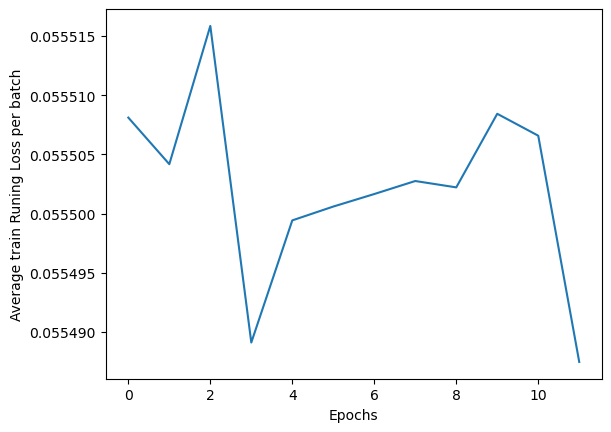

In [32]:
epoch_arr = np.arange(0, len(avg_train_loss_list))
plt.plot(avg_train_loss_list[190:202])
plt.xlabel("Epochs")
plt.ylabel("Average train Runing Loss per batch")
plt.show()

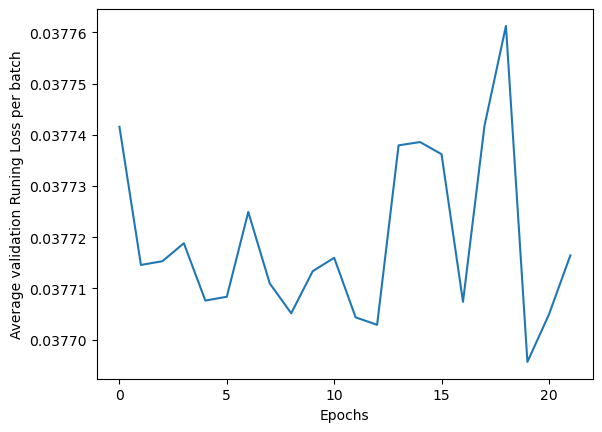

In [36]:
epoch_arr = np.arange(0, len(val_loss_list))
plt.plot(val_loss_list[180:202])
plt.xlabel("Epochs")
plt.ylabel("Average validation Runing Loss per batch")
plt.show()

In [21]:
torch.save(final_model_trainset, 'model_100206_13g_02_retrain_trainset.pt')

In [22]:
torch.save(final_model_valset, 'model_100206_13g_02_retrain_valset.pt')

In [37]:
np.save('val_loss_list_13_02.npy', val_loss_list)

In [38]:
np.save('train_loss_list_13_02.npy', train_loss_list)

In [39]:
np.save('avg_train_loss_list_13_02.npy', avg_train_loss_list)